## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

import warnings
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.utils import resample

from sklearn import metrics
import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier


In [40]:
pd.set_option('display.max_columns', None)

## Import Data

In [3]:
asos = pd.read_csv('data/asos_clean.csv')

In [4]:
asos

,name,price,#search,#brand,categories,#colour,#1,#1num,#2,#2num,potential_hashtag
0,New Look trench coat in camel,49.99,coat,stradivarius,coats,beige,beigecoat,30000,stradivariuscoat,1600,31600
1,New Look trench coat in camel,49.99,coat,stradivarius,coats,beige,beigecoat,30000,stradivariuscoat,1600,31600
2,New Look trench coat in camel,49.99,coat,asos design,coats,beige,beigecoat,30000,asosdesigncoat,3,30003
3,New Look trench coat in camel,49.99,coat,new look,coats,beige,beigecoat,30000,newlookcoat,888,30888
4,Stradivarius double breasted wool coat in grey,59.99,coat,stradivarius,coats,grey,greycoat,36000,stradivariuscoat,1600,37600
...,...,...,...,...,...,...,...,...,...,...,...
29772,ASOS DESIGN satin midi dress with cowl neck an...,55.00,dress,asos design,dresses,brown,browndress,68000,asosdesigndress,53,68053
29773,Urban Revivo square neck mini dress in floral ...,44.00,minidress,urban revivo,dresses,pattern,patternminidress,8,urbanrevivominidress,0,8
29774,ASOS DESIGN long sleeve maxi t-shirt dress in ...,24.00,dress,asos design,dresses,black,blackdress,4900000,asosdesigndress,53,4900053
29775,ASYOU layered t-shirt dress with focus graphic...,22.99,dress,asyou,dresses,black,blackdress,4900000,asyoudress,9,4900009


## EDA

### Dealing with Outliers

In [43]:
#check for outliers.

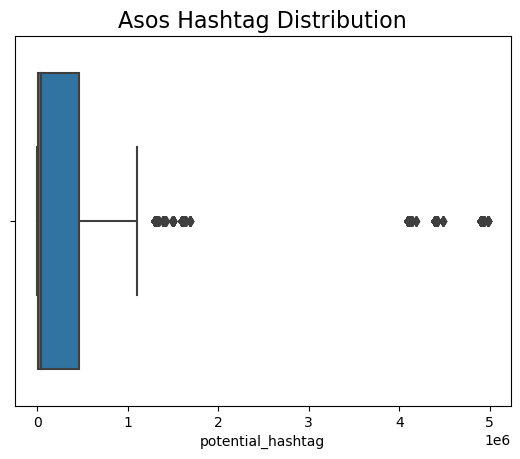

In [44]:
sns.boxplot(x=asos['potential_hashtag'])
plt.title('Asos Hashtag Distribution', fontsize=16)
plt.show()

In [45]:
#IQR#

In [46]:
asos[asos['potential_hashtag'] >np.quantile(asos['potential_hashtag'], q=0.75)].count()
#q75


name                 6661
price                6661
#search              6661
#brand               6661
categories           6661
#colour              6661
#1                   6661
#1num                6661
#2                   6661
#2num                6661
potential_hashtag    6661
dtype: int64

I'm going to create a new colum with the potential hashtags above 65% quantile as 'High' (indicates the hashtags that are trendy) or 'Low' for the ones under (indicates the hashtags that are not very trendy). I will use this later for my recommender.


In [47]:
new_list = []

for i in asos['potential_hashtag']:
    if i >np.quantile(asos['potential_hashtag'], q=0.65):
        new_list.append('High')
    else:
        new_list.append('Low')


In [48]:
asos['trendy'] = new_list #target for a classifier model

In [49]:
q25 = np.quantile(asos['potential_hashtag'], q=0.25)
q25


5727.0

## Feature Selection

The idea of feature selection is that you don't have too much multicolinearity, which could **give the algorithm away to the model**. Generally, the rule is that anything above 0.85-0.90 will need to be extensively reviewed before feeding it into the model, and one of the offending columns dropped. 

### CASE: A lower number of columns

In [50]:
#to check the correlation
asos.corr()

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_8479/2372417591.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  asos.corr()


,price,#1num,#2num,potential_hashtag
price,1.000000,0.122991,0.077001,0.123327
#1num,0.122991,1.000000,0.083711,0.999987
#2num,0.077001,0.083711,1.000000,0.088734
potential_hashtag,0.123327,0.999987,0.088734,1.000000


In [51]:
asos = asos.loc[asos['#search'].isin(list(asos['#search'].value_counts()[asos['#search'].value_counts() >10].index))]


In [52]:
asos = asos.loc[asos['#brand'].isin(list(asos['#brand'].value_counts()[asos['#brand'].value_counts() >10].index))]


In [53]:
asos = asos.loc[asos['#colour'].isin(list(asos['#colour'].value_counts()[asos['#colour'].value_counts() >10].index))]


In [54]:
asos = asos.reset_index(drop=True)

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_8479/1736732128.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations_matrix = asos.corr()


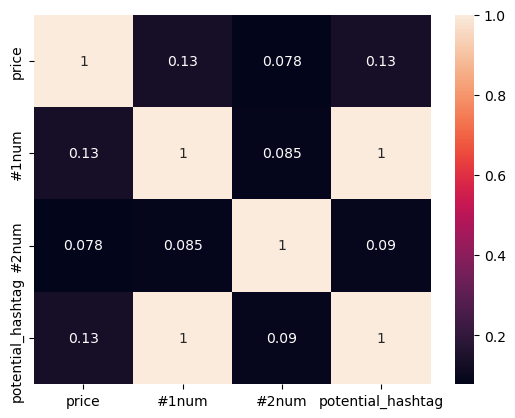

In [55]:
#clearer version of the above
correlations_matrix = asos.corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

/var/folders/75/lxv2pt816y3g7mh_b0zy07mw0000gn/T/ipykernel_8479/1530991478.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = asos.corr().loc[:,['potential_hashtag']]


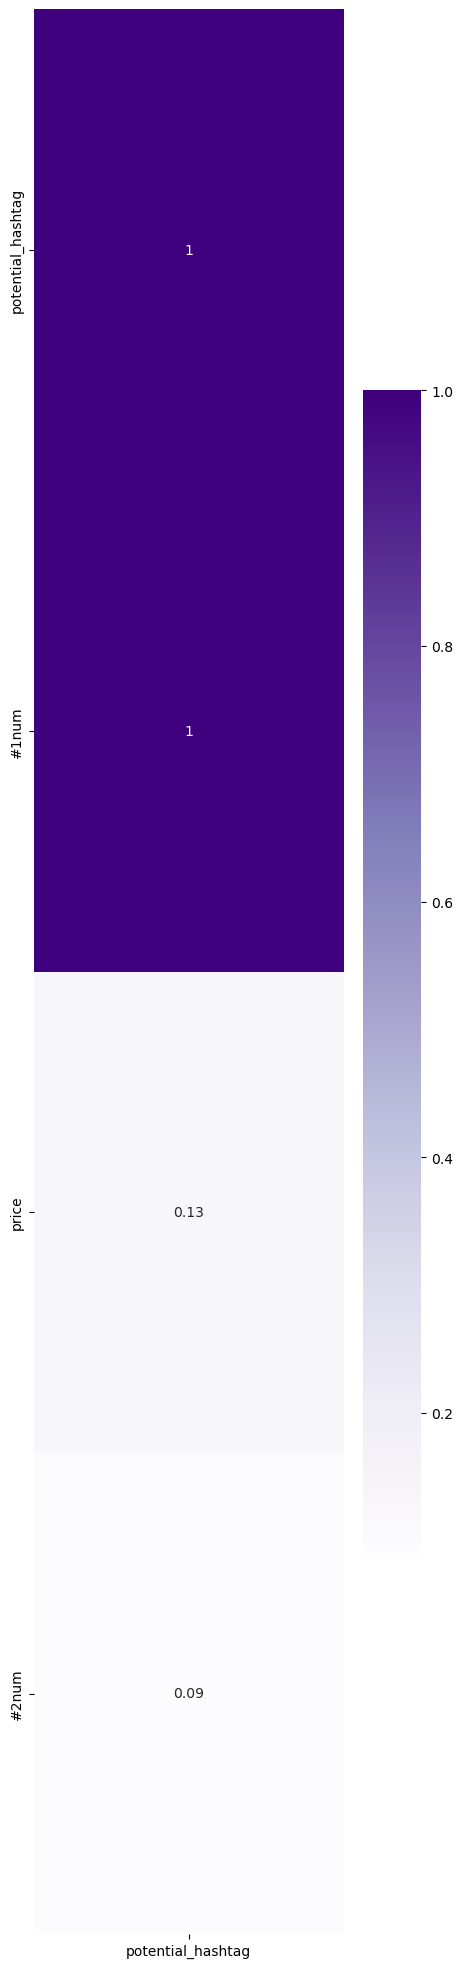

In [56]:
#Visualise the Correlation of columns in a vertical heatmap. this is useful for the number of features on the higher end of the spectrum
corr = asos.corr().loc[:,['potential_hashtag']]
fig, ax = plt.subplots(figsize=(5,25))
ax = sns.heatmap(corr.sort_values(by=['potential_hashtag'],ascending=False), ax=ax,annot=True,cbar=True,cmap="Purples")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)
plt.show()

We see that, of course, ther's a big correlation between #1, #2 and potencial_hashtags, so we will NOT use #1 and #2

In [57]:
#sns.pairplot(asos)
#plt.show()

# Building the model

## Xy Split

Our model will predict the **how trendy** a product is based on the number of Instagram hashtags.

In [58]:
y = asos[['trendy']]
X = asos[['price', '#search', '#brand', 'categories' ,'#colour']]

## Train Test Split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # default split ratio is 80/20

## Categorical, Numerical Split

In [60]:
#split train data
X_train_numerical = X_train[['price']]
X_train_categorical = X_train[['#search', '#brand', 'categories' ,'#colour']]


#split test data
X_test_numerical = X_test[['price']]
X_test_categorical = X_test[['#search', '#brand', 'categories' ,'#colour']]


## Dealing with numericals

### MinMax Scaler

- **Min-max scaler**
    - squish the data so that the smallest value is 0 and the highest value is 1 (put the data on a scale from 0 to 1)

In [61]:
#Fit ONLY the train set.
MinMaxtransformer = MinMaxScaler().fit(X_train_numerical)

#Train
X_train_normalized = MinMaxtransformer.transform(X_train_numerical)
X_train_minmax = pd.DataFrame(X_train_normalized,columns=X_train_numerical.columns)
#X_train_minmax.head()

#Test
X_test_normalized = MinMaxtransformer.transform(X_test_numerical)
X_test_minmax = pd.DataFrame(X_test_normalized,columns=X_test_numerical.columns)
#X_test_minmax.head()

Use Min-max scaler:

- When you want features to be between 0 and 1
- For algorithms that assume data is within a particular range (Neural networks for example)
- When data is not normal
- For computer vision problems
- When you want to preserve relative distances between points

## Dealing with categorical data

When considering categorical columns, we need to understand how we will be encoding them.

- If the unique values in our data is hierarchical, we need to **Ordinally** encode them.\ 

- If, however they are "Yes/No" values, they will need to be **OneHot encoded**. 

### OneHot Encoding

In [62]:
#Fit ONLY the train set. 
encoder = OneHotEncoder(drop='first').fit(X_train_categorical)


#Train
encoded_for_p_train = encoder.transform(X_train_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_categorical.columns)
X_train_ohe = pd.DataFrame(encoded_for_p_train, columns=cols)
#X_train_ohe.head()


#Test
encoded_for_p_test = encoder.transform(X_test_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_categorical.columns)
X_test_ohe = pd.DataFrame(encoded_for_p_test, columns=cols)
#X_test_ohe.head()

### MinMaxscaler

In [63]:
###Reset Indices###
X_train_minmax = X_train_minmax.reset_index(drop = True)
X_test_minmax = X_test_minmax.reset_index(drop = True)



#####Concat#####

#Train
X_train_treated = pd.concat([X_train_minmax,X_train_ohe], axis = 1)

#Test
X_test_treated = pd.concat([X_test_minmax,X_test_ohe], axis = 1)

## Reset the Incides of our y axes, so that they correspond to the X_train_scaled and X_test_scaled

In [66]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

## Fit Model

Now we are going to try a logistic regression model.

In [67]:
LR = LogisticRegression(random_state=0, solver='saga').fit(X_train_treated, y_train)

/Users/beamoralesquel/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [68]:
LR.score(X_test_treated, y_test)

0.9895412844036697

In [69]:
pred_untreat = LR.predict(X_test_treated)

In [70]:
print(metrics.classification_report(y_test, pred_untreat))

              precision    recall  f1-score   support

        High       0.99      0.98      0.99      2003
         Low       0.99      0.99      0.99      3447

    accuracy                           0.99      5450
   macro avg       0.99      0.99      0.99      5450
weighted avg       0.99      0.99      0.99      5450



We have a high score, good!

## Model Evaluation

In [76]:
# Train the model with standardised values
knn_st = KNeighborsClassifier(n_neighbors=3) #the classifier will look at the 3 nearest data points (or neighbors) in the training set to decide on the class label for a new, unseen data point.
knn_st.fit(X_train_treated, y_train)

/Users/beamoralesquel/anaconda3/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [77]:
# Evaluate the model with standardised values

preds_st = knn_st.predict(X_test_treated)
cm = metrics.confusion_matrix(y_test, preds_st)
cm

array([[1993,   10],
       [  67, 3380]])

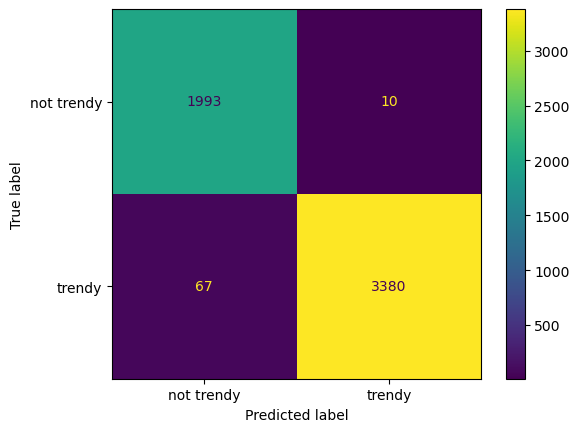

In [79]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not trendy", "trendy"])
disp.plot()

The model seems very accurate, it has only been wrong 77 times out of 5400+.